In [1]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import morphology as mr
from skimage import registration as reg
from skimage import util
from scipy import ndimage as ndi
import imageio.v3 as iio
%matplotlib inline

In [2]:
# Load data
snaps = [iio.imread(f'./molla/frame_{i:02d}.png') for i in range(17)]

In [3]:
# Generate gray scale images (average RGB channels)
frames = [s.mean(axis=-1) for s in snaps]

In [4]:
# Extract background frame
background = frames[3]

# Frame with A4 paper
calib = frames[2] - background

# Actual measurements
f0 = [f-background for f in frames[5:]] 

In [5]:
# Match A4 paper
import utils
rc = utils.find_rectangles((abs(calib)>50), apply_threshold=False)

Text(0.5, 1.0, 'A4 match')

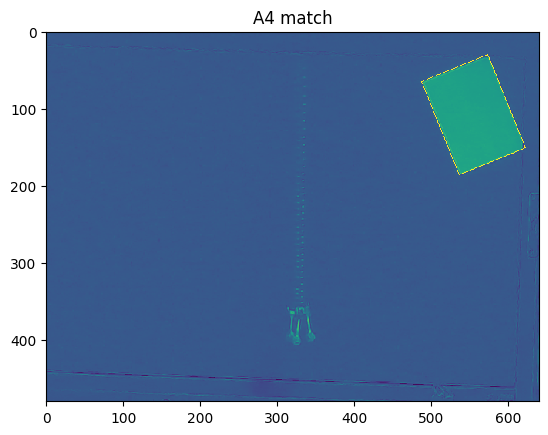

In [6]:
# Draw frame to confirm
import cv2
out = calib.copy()
cv2.drawContours(out, [rc[0][3]], -1, 255, thickness=1)
plt.figure()
plt.imshow(out)
plt.title('A4 match')

In [7]:
# Long side of the rectangle
long_side_px = np.max(rc[0][2][1])

# Find pixel size given long side = 297 mm
psize_mm = 297./long_side_px

# Error in pixel size
dpx = 3.

dpsize_mm = psize_mm * dpx/long_side_px

psize_m = psize_mm * 1e-3
dpsize_m = dpsize_mm * 1e-3

print(f'One pixel corresponds to {psize_mm:3.2f} ± {dpsize_mm:3.2f} mm')

One pixel corresponds to 2.28 ± 0.05 mm


In [8]:
# Raw pixel estimate of the lower part of the spring 
y = np.array([65.8,
    63.6,
    62.6,
    165.0,
    168.9,
    166.5,
    268.5,
    267.1,
    266.6,
    364.5,
    366.6,
    366.8])

# Estimated error
dy = 2.

# Corresponding number of Chuppa Chups
n = np.array([0.,
     0,
     0,
     1,
     1,
     1,
     2,
     2,
     2,
     3,
     3,
     3])

# Conversion to physical quantities
m = n*.013                # Mass in kg
h = y * psize_m      # Height in m
dh = h * (dy/y + dpsize_m/psize_m)    # height uncertainty


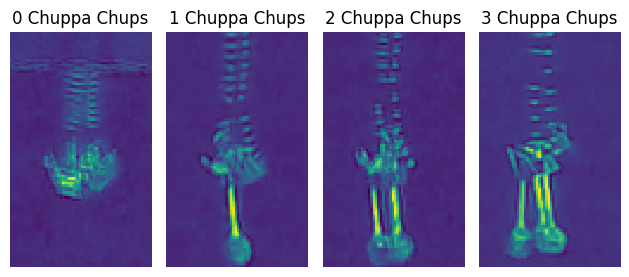

In [9]:
# Plots the regions-of-interest to confirm that the spring
# extension point has been correctly identified.
fig, ax = plt.subplots(1,4)
i=0
for k in range(4):
    im0 = None
    for l in range(3):
        if im0 is None:
            im0 = f0[i][int(y[i])-50:int(y[i])+50,297:357].astype(float)
        else:
            im0 += f0[i][int(y[i])-50:int(y[i])+50,297:357]
        i+=1
    ax[k].imshow(im0)
    ax[k].axis('off')
    ax[k].set_title(f'{k} Chuppa Chups')
fig.tight_layout()

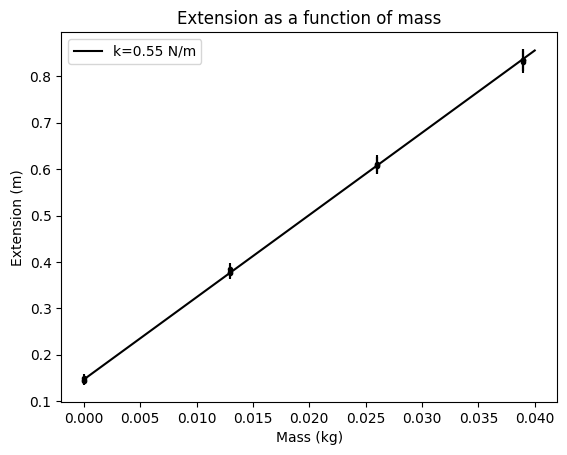

In [10]:
# Linear fit
a1, a0 = np.polyfit(x=m, y=h, deg=1, w=1/dh)

# Spring constant in N/m
k = 9.81/a1

plt.figure()
plt.errorbar(m, h, dh, fmt='k.')
mt = np.array([0, .04])
ht = a0 + a1*mt
plt.plot(mt, ht, 'k-', label=f'k={k:3.2g} N/m')
plt.xlabel('Mass (kg)')
plt.ylabel('Extension (m)')
plt.legend()
plt.title('Extension as a function of mass');